# Sweden OC Mapping
This toturial consists of multiple notebook, which has different task. First is prepration. 

## Prepration of covariates
This can be done via soilhealth datacube or finding each covariates seperately. 

### Import shp file of the area 
Shape file is extracted from Tiff layer of this study: Digital soil mapping of arable land in Sweden (A spatial database of cultivated arable land derived from the EU subsidies database of the Swedish Board of Agriculture (SJV; Jordbruksverket, Jönköping, Sweden), the so-called ‘Block Map’ (from 2013), was used to delineate the area of interest map in detail )

In [2]:
#IMPORT Landcover Sweden
import os
import geopandas as gpd

#Set the working directory 
os.chdir('C:/Negar/DSM_Sweden/')  
# Replace 'path_to_shapefile.shp' with your actual shapefile path
arable_land_SE = 'shp file/arable_land_SE.shp'
SE_shp = gpd.read_file(arable_land_SE)
print('crs of SE_shp',SE_shp.crs)
SE_shp.head()

crs of SE_shp EPSG:3006


,fid,DN,geometry
0,1.0,4,"POLYGON ((619450 6885000, 619500 6885000, 6195..."
1,2.0,5,"POLYGON ((590800 6885000, 590850 6885000, 5908..."
2,3.0,4,"POLYGON ((619350 6884950, 619450 6884950, 6194..."
3,4.0,5,"POLYGON ((619500 6885000, 619550 6885000, 6195..."
4,5.0,5,"POLYGON ((603150 6884900, 603200 6884900, 6032..."


### Accessing and using SoilHealthDataCube

In [3]:
#%pip install altair
#%pip install pystac-client

In [5]:
from pystac_client import Client

# Connect to a public STAC API (this is NASA Earth Search)
stac_ecodatacube_url = "https://s3.ecodatacube.eu/arco/stac/catalog.json"
catalog = Client.open(stac_ecodatacube_url)

# Print collections available
for collection in catalog.get_collections():
    print(f"{collection.id}: {collection.description}")

c:\Users\faha6654\AppData\Local\Programs\Python\Python312\Lib\site-packages\pystac_client\client.py:186: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())
c:\Users\faha6654\AppData\Local\Programs\Python\Python312\Lib\site-packages\pystac_client\client.py:441: FallbackToPystac: Falling back to pystac. This might be slow.
  self._warn_about_fallback("COLLECTIONS", "FEATURES")


accum.precipitation_chelsa.montlhy: Monthly accumulated precipitation in mm at 1 km resolution based on CHELSA.
soil.types_ensemble_prob: Ensemble prediction of the probability of a specific soil type, stable over time
soil.types_ensemble: Ensemble prediction of hard classification soil type maps, stable over time
lst_mod11a2.nighttime: Night-time land surface temperature, derived from MOD11A2, monthly aggregated considering three percentiles (p05, p50 and p95) and standard deviation of cloud-free pixels. All months were gapfilled by TMWM, which uses cloud-free pixel values from diferent periods to interpolate the missing values.
lst_mod11a2.daytime: Day-time land surface temperature, derived from MOD11A2, monthly aggregated considering three percentiles (p05, p50 and p95) and standard deviation of cloud-free pixels. All months were gapfilled by TMWM, which uses cloud-free pixel values from diferent periods to interpolate the missing values.
wv_mcd19a2v061.seasconv: The monthly aggrega

In [6]:
collection_id = "geomorphon_edtm" # Collection ID
dfme_collection = catalog.get_child(collection_id)
dfme_collection

<CollectionClient id=geomorphon_edtm>

This code block is working with the STAC API using the pystac Python library to extract URLs of raster files, specifically GeoTIFF and Cloud-Optimized GeoTIFF (COG) files. This cell does the following:

Loads a STAC collection

Filters for raster data (GeoTIFF/COG)

Extracts direct URLs to those files

Prepares you for further processing, e.g. downloading, clipping, or visualizing

In [6]:
import pystac
media_types = [pystac.MediaType.GEOTIFF, pystac.MediaType.COG]

raster_urls = []

for collection_item in ndti_collection.get_all_items():
    for item_id, item in collection_item.get_assets().items():
        if item.media_type in media_types:
          raster_urls.append(item.href)

print(f"Collection {collection_id} COG URLS ({len(raster_urls)} files)")
print(f'First URL: {raster_urls[0]}')

c:\Users\faha6654\AppData\Local\Programs\Python\Python312\Lib\site-packages\pystac_client\collection_client.py:149: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("ITEM_SEARCH")


Collection ndti_glad.landsat.ard2.seasconv COG URLS (138 files)
First URL: https://s3.ecodatacube.eu/arco/ndti_glad.landsat.ard2.seasconv_m_30m_s_20000101_20000228_eu_epsg.3035_v20231127.tif


In [7]:
#%pip install rasterio

Now we can create a function to iterate two part of the data
1. field: each row of `field_bounds`,
2. time series: each items in `raster_urls`

In [8]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from rasterio.mask import mask

def fetch_ndti_for_field(field_bounds, row, raster_urls, raster_image):
  # Reproject polygon to match raster CRS (optional but important)
  with rasterio.open(raster_urls[raster_image]) as src:
      if field_bounds.crs != src.crs:
          field_bounds = field_bounds.to_crs(src.crs)

      # Convert geometry to GeoJSON-like mapping
      geometry = [field_bounds.geometry.iloc[row].__geo_interface__]

      # Mask the raster with the polygon
      out_image, out_transform = mask(src, geometry, crop=True)
      out_meta = src.meta

  # out_image is a 3D array: (bands, height, width)
  # Let's grab the first band and show it
  matrix = out_image[0].astype(float)
  # Mask out nodata
  matrix[matrix==255]=np.nan
  # Scale according to the metadata
  matrix= (matrix-125)/125
  return matrix

In [9]:
fetch_ndti_for_field(SE_shp,0,raster_urls,0)

array([[  nan,   nan,   nan],
       [  nan, 0.232,   nan],
       [  nan,   nan,   nan]])

In [ ]:
#%pip install bottleneck
import bottleneck as bn


# Iterate for all fields
field_ids=[]
field_means=[]
field_stds=[]
for i in SE_shp.iterrows():
  field_ids.append(i[1].DN)
  field_matrix = fetch_ndti_for_field(SE_shp,i[0],raster_urls,0)
  field_means.append(bn.nanmean(field_matrix))
  field_stds.append(bn.nanstd(field_matrix))


In [ ]:
import os
import geopandas as gpd
from pystac_client import Client
import pystac
import rasterio
from rasterio.mask import mask

# shapefile path
arable_land_SE = 'shp file/arable_land_SE.shp'
SE_shp = gpd.read_file(arable_land_SE)
print('CRS of SE_shp:', SE_shp.crs)

# STAC API
stac_ecodatacube_url = "https://s3.ecodatacube.eu/arco/stac/catalog.json"
catalog = Client.open(stac_ecodatacube_url)

# Collection ID
collection_id = "geomorphon_edtm"  # 👈 این رو تغییر بده به کالکشن ثابت موردنظر
collection = catalog.get_child(collection_id)

# Extract raster URLs from the collection
media_types = [pystac.MediaType.GEOTIFF, pystac.MediaType.COG]
raster_urls = []

for collection_item in collection.get_all_items():
    for item_id, item in collection_item.get_assets().items():
        if item.media_type in media_types:
            raster_urls.append(item.href)

print(f"Collection '{collection_id}' — Found {len(raster_urls)} raster files.")

# Clip Function
def clip_raster_with_shape(field_bounds, raster_url, output_dir="output"):
    with rasterio.open(raster_url) as src:
        if field_bounds.crs != src.crs:
            field_bounds = field_bounds.to_crs(src.crs)

        # Merge all polygons into a single geometry
        geometry = [field_bounds.unary_union.__geo_interface__]

        out_image, out_transform = mask(src, geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "crs": src.crs
        })

        raster_name = os.path.basename(raster_url).split('.')[0]
        output_filename = f"{raster_name}_clipped.tif"
        output_path = os.path.join(output_dir, output_filename)

        os.makedirs(output_dir, exist_ok=True)
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

        print(f"✔️ Saved: {output_path}")

    return output_path

# Clip all rasters with the shapefile
output_dir = "output"

for raster_url in raster_urls:
    clip_raster_with_shape(SE_shp, raster_url, output_dir)


let's try with districts

CRS of districts_shp: EPSG:3035
CRS of SE_shp: EPSG:3006
  CNTR_CODE  ID  clust                                           geometry
0        SE   1      6  POLYGON ((4762647.273 4069687.732, 4762735.86 ...
1        SE   2      5  POLYGON ((4797776.137 4080133.319, 4796669.805...
2        SE   3      5  MULTIPOLYGON (((4826035.521 4076862.713, 48262...
3        SE   4      6  MULTIPOLYGON (((4843657.954 4070002.64, 484387...
4        SE   5      6  POLYGON ((4761916.506 4056404.111, 4760904.301...


C:\Users\faha6654\AppData\Local\Temp\ipykernel_18460\3058663823.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  arable_in_district = SE_shp[SE_shp.intersects(district.geometry.unary_union)]


Arable land in district 2:              fid  DN                                           geometry
597645  597646.0   3  POLYGON ((4614295.517 3921777.676, 4614345.475...
597744  597745.0   3  POLYGON ((4613753.285 3921639.426, 4613803.243...
597978  597979.0   3  POLYGON ((4613653.369 3921632.408, 4613703.327...
598221  598222.0   3  POLYGON ((4614663.48 3921553.107, 4614713.437 ...
598222  598223.0   4  POLYGON ((4614813.353 3921563.632, 4614863.31 ...
...          ...  ..                                                ...
987362  987363.0   3  POLYGON ((4533924.739 3672675.601, 4533974.654...
987485  987486.0   3  POLYGON ((4532541.484 3672377.513, 4532641.314...
987630  987631.0   3  POLYGON ((4532498.751 3672274.27, 4532598.581 ...
988507  988508.0   3  POLYGON ((4533586.466 3671799.799, 4533686.295...
988579  988580.0   3  POLYGON ((4533561.686 3671447.257, 4533611.601...

[181154 rows x 3 columns]


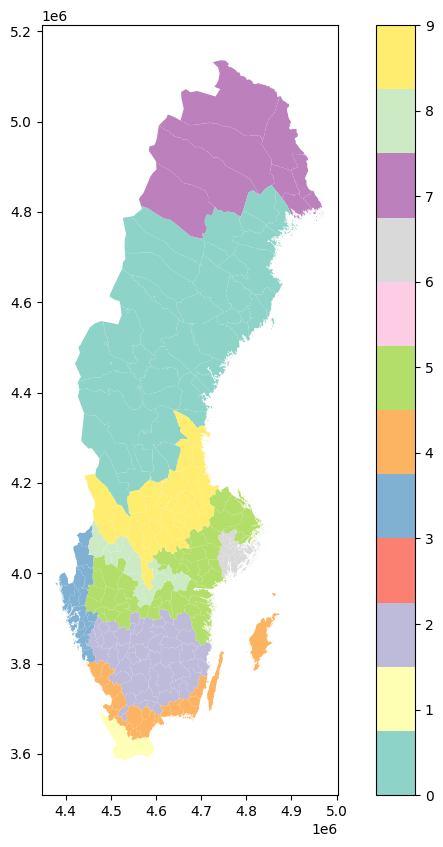

In [ ]:
import geopandas as gpd
districts_path= 'C:/Negar/Soil_DistrictsPaper/On_soil_districts/SE_10/10_SC1.shp'
districts_shp = gpd.read_file(districts_path)
print('CRS of districts_shp:', districts_shp.crs)

#plot districts with cluster names
districts_shp.plot(column='clust', cmap='Set3', legend=True, figsize=(10, 10)) 

# open arable land shapefile
arable_land_SE = 'shp file/arable_land_SE.shp'
SE_shp = gpd.read_file(arable_land_SE) 
print('CRS of SE_shp:', SE_shp.crs)

# Reproject to match CRS of districts
SE_shp = SE_shp.to_crs(districts_shp.crs)

print(districts_shp.head())

#Select one district and then select the arable land within that district
district_clust = 2  # Replace with the desired district cluster
district = districts_shp[districts_shp['clust'] == district_clust]
arable_in_district = SE_shp[SE_shp.intersects(district.geometry.unary_union)]
print(f"Arable land in district {district_clust}:", arable_in_district)

#

In [14]:
# Save the arable land within the district to a new shapefile
output_arable_path = 'arable_land_district_{}.shp'.format(district_clust)
arable_in_district.to_file(output_arable_path)
# Print the path of the saved shapefile
#print(f"Arable land within district {district_clust} saved to: {output_arable_path}")


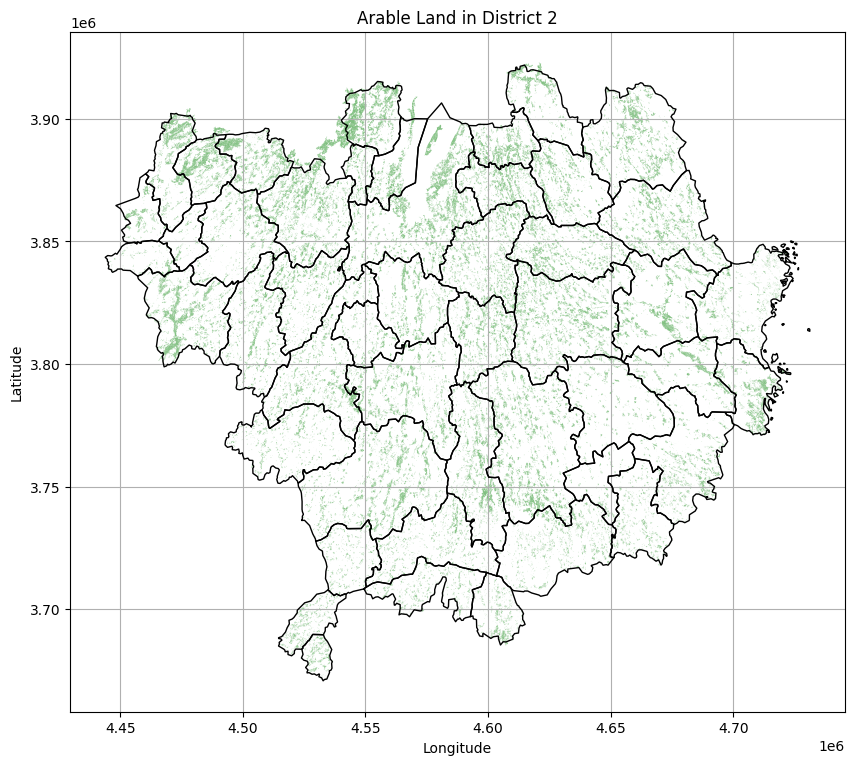

In [13]:
# Plot the arable land within the district
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
district.boundary.plot(ax=ax, color='black', linewidth=1)
arable_in_district.plot(ax=ax, color='green', alpha=0.5)        
plt.title(f'Arable Land in District {district_clust}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

In [ ]:
covariates = {
    "CHELSA_Monthly_Precip": "https://stac.ecodatacube.eu/accum.precipitation_chelsa.montlhy/collection.json",
    "ERA5_Monthly_Temp": "https://stac.ecodatacube.eu/clm_air.temp_era5.copernicus/collection.json",
    "EVI_Bimonthly": "https://stac.ecodatacube.eu/evi_glad.landsat.ard2.seasconv/collection.json",
    "NDSI_Bimonthly": "https://stac.ecodatacube.eu/ndsi_glad.landsat.ard2.seasconv/collection.json",
    "SAVI_Bimonthly": "https://stac.ecodatacube.eu/savi_glad.landsat.ard2.seasconv/collection.json",
    "BSF_Yearly": "https://stac.ecodatacube.eu/bsf_glad.landsat.ard2.seasconv.m.yearly/collection.json",
    "NDVI_Yearly": "https://stac.ecodatacube.eu/ndvi_glad.landsat.ard2.seasconv.m.yearly/collection.json",
    "BSF_Yearly": "https://stac.ecodatacube.eu/bsf_glad.landsat.ard2.seasconv.m.yearly/collection.json",
    "NIR_Yearly": "https://stac.ecodatacube.eu/nir_glad.landsat.ard2.seasconv.m.yearly/collection.json",
    "NDWI_Yearly": "https://stac.ecodatacube.eu/ndwi.gao_glad.landsat.ard2.seasconv.m.yearly/collection.json",
    "NDTI_Yearly": "https://stac.ecodatacube.eu/ndti_glad.landsat.ard2.seasconv.m.yearly/collection.json",
    "Red_Yearly": "https://stac.ecodatacube.eu/red_glad.landsat.ard2.seasconv.m.yearly/collection.json",
    "SWIR2_Yearly": "https://stac.ecodatacube.eu/swir2_glad.landsat.ard2.seasconv.m.yearly/collection.json",
    "SWIR1_Yearly": "https://stac.ecodatacube.eu/swir1_glad.landsat.ard2.seasconv.m.yearly/collection.json",
    "Green_Yearly": "https://stac.ecodatacube.eu/green_glad.landsat.ard2.seasconv.m.yearly/collection.json",
    "Blue_Yearly": "https://stac.ecodatacube.eu/blue_glad.landsat.ard2.seasconv.m.yearly/collection.json",
}